## Importing libraries

In [1]:
from __future__ import print_function, division

from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU

import matplotlib.pyplot as plt
import sys
import numpy as np

Using TensorFlow backend.
C:\Users\himan\Anaconda3\envs\tensorflow2\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\himan\Anaconda3\envs\tensorflow2\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\himan\Anaconda3\envs\tensorflow2\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\himan\Anaconda3\envs

In [2]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
latent_dim = 100

optimizer = Adam(0.0002, 0.5)

In [3]:
def build_generator():
    model = Sequential()

    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    #model.add(Dense(2048))
    #model.add(LeakyReLU(alpha=0.2))
    #model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    model.summary()

    noise = Input(shape=(latent_dim,))
    img = model(noise)

    return Model(noise, img)

In [4]:
def build_discriminator():
    model = Sequential()

    model.add(Flatten(input_shape=img_shape))
    #model.add(Dense(512))
    #model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)

In [5]:
def sample_images(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    #fig.savefig("images/%d.png" % epoch)
    plt.show()
    plt.close()

In [6]:
def train(epochs, batch_size=128, sample_interval=50):

    # Load the dataset
    (X_train, _), (_, _) = fashion_mnist.load_data()

    # Rescale -1 to 1
    X_train = X_train / 127.5 - 1.
    X_train = np.expand_dims(X_train, axis=3)

    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random batch of images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        noise = np.random.normal(0, 1, (batch_size, latent_dim))

        # Generate a batch of new images
        gen_imgs = generator.predict(noise)

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(imgs, valid)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        noise = np.random.normal(0, 1, (batch_size, latent_dim))

        # Train the generator (to have the discriminator label samples as valid)
        g_loss = combined.train_on_batch(noise, valid)

        # Plot the progress
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

        # If at save interval => save generated image samples
        if epoch % sample_interval == 0:
            sample_images(epoch)

In [7]:
# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])

# Build the generator
generator = build_generator()

# The generator takes noise as input and generates imgs
z = Input(shape=(latent_dim,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
validity = discriminator(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

W1013 23:47:42.811226 13984 deprecation_wrapper.py:119] From C:\Users\himan\Anaconda3\envs\tensorflow2\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1013 23:47:42.812819 13984 deprecation_wrapper.py:119] From C:\Users\himan\Anaconda3\envs\tensorflow2\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1013 23:47:42.829149 13984 deprecation_wrapper.py:119] From C:\Users\himan\Anaconda3\envs\tensorflow2\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1013 23:47:42.881030 13984 deprecation_wrapper.py:119] From C:\Users\himan\Anaconda3\envs\tensorflow2\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1013 23:47:

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

## Training process

C:\Users\himan\Anaconda3\envs\tensorflow2\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.845510, acc.: 32.81%] [G loss: 0.748515]


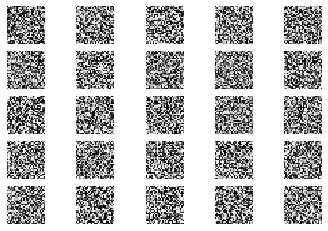

C:\Users\himan\Anaconda3\envs\tensorflow2\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 0.479732, acc.: 78.12%] [G loss: 0.775949]
2 [D loss: 0.358648, acc.: 84.38%] [G loss: 0.877100]
3 [D loss: 0.279467, acc.: 90.62%] [G loss: 1.058080]
4 [D loss: 0.315206, acc.: 89.06%] [G loss: 1.217484]
5 [D loss: 0.209971, acc.: 100.00%] [G loss: 1.217236]
6 [D loss: 0.238069, acc.: 93.75%] [G loss: 1.447114]
7 [D loss: 0.189380, acc.: 100.00%] [G loss: 1.527622]
8 [D loss: 0.170402, acc.: 100.00%] [G loss: 1.594225]
9 [D loss: 0.122250, acc.: 100.00%] [G loss: 1.718290]
10 [D loss: 0.149756, acc.: 100.00%] [G loss: 1.896712]
11 [D loss: 0.122901, acc.: 100.00%] [G loss: 1.848939]
12 [D loss: 0.124476, acc.: 100.00%] [G loss: 1.954869]
13 [D loss: 0.110920, acc.: 100.00%] [G loss: 2.006686]
14 [D loss: 0.102319, acc.: 100.00%] [G loss: 2.156984]
15 [D loss: 0.092136, acc.: 100.00%] [G loss: 2.052168]
16 [D loss: 0.078103, acc.: 100.00%] [G loss: 2.296259]
17 [D loss: 0.071301, acc.: 100.00%] [G loss: 2.259425]
18 [D loss: 0.077212, acc.: 100.00%] [G loss: 2.326844]
19 [D 

150 [D loss: 0.188537, acc.: 98.44%] [G loss: 3.850819]
151 [D loss: 0.160880, acc.: 95.31%] [G loss: 4.345994]
152 [D loss: 0.304543, acc.: 87.50%] [G loss: 3.619173]
153 [D loss: 0.102209, acc.: 96.88%] [G loss: 4.018168]
154 [D loss: 0.334738, acc.: 87.50%] [G loss: 3.311034]
155 [D loss: 0.120479, acc.: 95.31%] [G loss: 4.020358]
156 [D loss: 0.217221, acc.: 92.19%] [G loss: 3.578504]
157 [D loss: 0.205816, acc.: 96.88%] [G loss: 3.227615]
158 [D loss: 0.135755, acc.: 93.75%] [G loss: 4.272161]
159 [D loss: 0.127115, acc.: 96.88%] [G loss: 4.253839]
160 [D loss: 0.328552, acc.: 84.38%] [G loss: 3.433740]
161 [D loss: 0.145430, acc.: 96.88%] [G loss: 3.229729]
162 [D loss: 0.141858, acc.: 95.31%] [G loss: 3.989857]
163 [D loss: 0.201610, acc.: 89.06%] [G loss: 3.927225]
164 [D loss: 0.323513, acc.: 93.75%] [G loss: 3.580637]
165 [D loss: 0.099442, acc.: 96.88%] [G loss: 3.630179]
166 [D loss: 0.230728, acc.: 85.94%] [G loss: 3.005278]
167 [D loss: 0.326180, acc.: 89.06%] [G loss: 3.

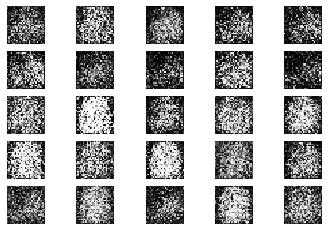

201 [D loss: 1.079899, acc.: 53.12%] [G loss: 2.146373]
202 [D loss: 0.381631, acc.: 79.69%] [G loss: 3.135946]
203 [D loss: 0.345464, acc.: 92.19%] [G loss: 2.749460]
204 [D loss: 0.349168, acc.: 89.06%] [G loss: 2.427089]
205 [D loss: 0.323780, acc.: 87.50%] [G loss: 2.522807]
206 [D loss: 0.404664, acc.: 81.25%] [G loss: 2.454983]
207 [D loss: 0.346766, acc.: 89.06%] [G loss: 3.179564]
208 [D loss: 0.417768, acc.: 85.94%] [G loss: 2.309256]
209 [D loss: 0.564421, acc.: 75.00%] [G loss: 2.095241]
210 [D loss: 0.318341, acc.: 89.06%] [G loss: 3.265871]
211 [D loss: 0.820685, acc.: 59.38%] [G loss: 1.939685]
212 [D loss: 0.245293, acc.: 90.62%] [G loss: 3.154322]
213 [D loss: 0.459485, acc.: 81.25%] [G loss: 2.321370]
214 [D loss: 0.240587, acc.: 90.62%] [G loss: 2.844311]
215 [D loss: 0.740207, acc.: 68.75%] [G loss: 2.099961]
216 [D loss: 0.279735, acc.: 90.62%] [G loss: 2.205873]
217 [D loss: 0.609495, acc.: 78.12%] [G loss: 2.446261]
218 [D loss: 0.490833, acc.: 79.69%] [G loss: 2.

348 [D loss: 0.608001, acc.: 70.31%] [G loss: 1.018410]
349 [D loss: 0.740175, acc.: 54.69%] [G loss: 1.009672]
350 [D loss: 0.560931, acc.: 71.88%] [G loss: 1.084108]
351 [D loss: 0.596501, acc.: 65.62%] [G loss: 1.067247]
352 [D loss: 0.615181, acc.: 62.50%] [G loss: 1.148784]
353 [D loss: 0.691179, acc.: 60.94%] [G loss: 1.077562]
354 [D loss: 0.580678, acc.: 76.56%] [G loss: 0.965736]
355 [D loss: 0.676963, acc.: 60.94%] [G loss: 1.009969]
356 [D loss: 0.658228, acc.: 65.62%] [G loss: 0.939628]
357 [D loss: 0.641854, acc.: 59.38%] [G loss: 1.083999]
358 [D loss: 0.611910, acc.: 64.06%] [G loss: 1.050231]
359 [D loss: 0.583990, acc.: 67.19%] [G loss: 1.014179]
360 [D loss: 0.651193, acc.: 57.81%] [G loss: 1.026650]
361 [D loss: 0.637984, acc.: 62.50%] [G loss: 0.961860]
362 [D loss: 0.608943, acc.: 68.75%] [G loss: 1.005007]
363 [D loss: 0.638591, acc.: 67.19%] [G loss: 1.087721]
364 [D loss: 0.729075, acc.: 56.25%] [G loss: 0.971265]
365 [D loss: 0.599800, acc.: 68.75%] [G loss: 1.

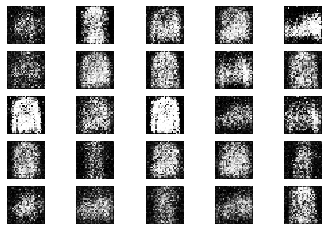

401 [D loss: 0.648805, acc.: 56.25%] [G loss: 0.988912]
402 [D loss: 0.577665, acc.: 73.44%] [G loss: 1.011531]
403 [D loss: 0.605869, acc.: 65.62%] [G loss: 1.076814]
404 [D loss: 0.538994, acc.: 65.62%] [G loss: 1.035603]
405 [D loss: 0.537624, acc.: 81.25%] [G loss: 1.104636]
406 [D loss: 0.559516, acc.: 78.12%] [G loss: 1.017217]
407 [D loss: 0.601719, acc.: 68.75%] [G loss: 1.090416]
408 [D loss: 0.603376, acc.: 68.75%] [G loss: 1.058316]
409 [D loss: 0.643889, acc.: 64.06%] [G loss: 1.060779]
410 [D loss: 0.560105, acc.: 75.00%] [G loss: 1.078630]
411 [D loss: 0.677768, acc.: 57.81%] [G loss: 1.101803]
412 [D loss: 0.621274, acc.: 59.38%] [G loss: 0.949740]
413 [D loss: 0.640540, acc.: 64.06%] [G loss: 0.975302]
414 [D loss: 0.641766, acc.: 57.81%] [G loss: 0.940444]
415 [D loss: 0.671086, acc.: 54.69%] [G loss: 1.006634]
416 [D loss: 0.578579, acc.: 68.75%] [G loss: 0.952007]
417 [D loss: 0.595065, acc.: 62.50%] [G loss: 1.047055]
418 [D loss: 0.678608, acc.: 59.38%] [G loss: 0.

553 [D loss: 0.638572, acc.: 71.88%] [G loss: 0.863713]
554 [D loss: 0.584847, acc.: 70.31%] [G loss: 1.030172]
555 [D loss: 0.625668, acc.: 67.19%] [G loss: 0.863235]
556 [D loss: 0.569272, acc.: 71.88%] [G loss: 0.910237]
557 [D loss: 0.608838, acc.: 64.06%] [G loss: 0.919424]
558 [D loss: 0.588769, acc.: 64.06%] [G loss: 0.919797]
559 [D loss: 0.623796, acc.: 64.06%] [G loss: 0.953183]
560 [D loss: 0.629262, acc.: 64.06%] [G loss: 0.988645]
561 [D loss: 0.674051, acc.: 57.81%] [G loss: 0.892135]
562 [D loss: 0.583449, acc.: 67.19%] [G loss: 0.864137]
563 [D loss: 0.630318, acc.: 67.19%] [G loss: 0.915877]
564 [D loss: 0.565004, acc.: 71.88%] [G loss: 0.963315]
565 [D loss: 0.654995, acc.: 64.06%] [G loss: 0.989961]
566 [D loss: 0.611935, acc.: 64.06%] [G loss: 0.948847]
567 [D loss: 0.650545, acc.: 54.69%] [G loss: 1.048836]
568 [D loss: 0.589239, acc.: 76.56%] [G loss: 0.960971]
569 [D loss: 0.725927, acc.: 60.94%] [G loss: 0.894522]
570 [D loss: 0.637078, acc.: 67.19%] [G loss: 0.

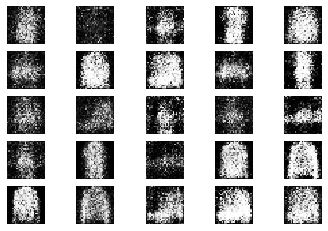

601 [D loss: 0.633949, acc.: 68.75%] [G loss: 0.963897]
602 [D loss: 0.664255, acc.: 57.81%] [G loss: 0.913047]
603 [D loss: 0.597906, acc.: 65.62%] [G loss: 0.850755]
604 [D loss: 0.653761, acc.: 60.94%] [G loss: 0.939933]
605 [D loss: 0.658128, acc.: 59.38%] [G loss: 0.989510]
606 [D loss: 0.586269, acc.: 76.56%] [G loss: 1.006839]
607 [D loss: 0.642862, acc.: 62.50%] [G loss: 0.959831]
608 [D loss: 0.588484, acc.: 67.19%] [G loss: 1.007004]
609 [D loss: 0.700095, acc.: 57.81%] [G loss: 0.785340]
610 [D loss: 0.640126, acc.: 57.81%] [G loss: 0.873255]
611 [D loss: 0.738506, acc.: 53.12%] [G loss: 0.806750]
612 [D loss: 0.615611, acc.: 65.62%] [G loss: 0.925566]
613 [D loss: 0.617634, acc.: 65.62%] [G loss: 0.913539]
614 [D loss: 0.613366, acc.: 68.75%] [G loss: 0.851743]
615 [D loss: 0.677315, acc.: 60.94%] [G loss: 0.896091]
616 [D loss: 0.700140, acc.: 56.25%] [G loss: 0.909898]
617 [D loss: 0.621652, acc.: 68.75%] [G loss: 0.867614]
618 [D loss: 0.576615, acc.: 71.88%] [G loss: 0.

748 [D loss: 0.653655, acc.: 62.50%] [G loss: 0.827904]
749 [D loss: 0.694511, acc.: 53.12%] [G loss: 0.832305]
750 [D loss: 0.630991, acc.: 65.62%] [G loss: 0.747687]
751 [D loss: 0.641577, acc.: 64.06%] [G loss: 0.798116]
752 [D loss: 0.631962, acc.: 59.38%] [G loss: 0.845085]
753 [D loss: 0.606014, acc.: 68.75%] [G loss: 0.888976]
754 [D loss: 0.671416, acc.: 60.94%] [G loss: 0.814849]
755 [D loss: 0.703755, acc.: 50.00%] [G loss: 0.825965]
756 [D loss: 0.651100, acc.: 59.38%] [G loss: 0.842314]
757 [D loss: 0.620068, acc.: 68.75%] [G loss: 0.846542]
758 [D loss: 0.661662, acc.: 60.94%] [G loss: 0.909084]
759 [D loss: 0.647998, acc.: 64.06%] [G loss: 0.850936]
760 [D loss: 0.595101, acc.: 68.75%] [G loss: 0.923175]
761 [D loss: 0.632914, acc.: 60.94%] [G loss: 0.818523]
762 [D loss: 0.645257, acc.: 62.50%] [G loss: 0.899481]
763 [D loss: 0.604950, acc.: 73.44%] [G loss: 0.842600]
764 [D loss: 0.649349, acc.: 60.94%] [G loss: 0.864036]
765 [D loss: 0.663616, acc.: 56.25%] [G loss: 0.

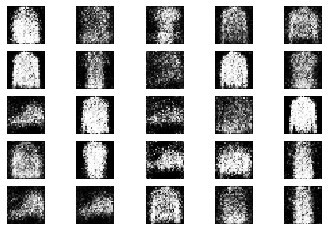

801 [D loss: 0.653203, acc.: 62.50%] [G loss: 0.836783]
802 [D loss: 0.647437, acc.: 60.94%] [G loss: 0.826533]
803 [D loss: 0.676068, acc.: 59.38%] [G loss: 0.892688]
804 [D loss: 0.650557, acc.: 57.81%] [G loss: 0.849730]
805 [D loss: 0.605081, acc.: 70.31%] [G loss: 0.845303]
806 [D loss: 0.624793, acc.: 68.75%] [G loss: 0.891441]
807 [D loss: 0.582851, acc.: 71.88%] [G loss: 0.900641]
808 [D loss: 0.656887, acc.: 60.94%] [G loss: 0.835209]
809 [D loss: 0.603790, acc.: 67.19%] [G loss: 0.889150]
810 [D loss: 0.628855, acc.: 62.50%] [G loss: 0.815747]
811 [D loss: 0.651773, acc.: 57.81%] [G loss: 0.803708]
812 [D loss: 0.662749, acc.: 64.06%] [G loss: 0.881226]
813 [D loss: 0.650716, acc.: 56.25%] [G loss: 0.921510]
814 [D loss: 0.629430, acc.: 65.62%] [G loss: 0.753497]
815 [D loss: 0.625864, acc.: 71.88%] [G loss: 0.854061]
816 [D loss: 0.645569, acc.: 59.38%] [G loss: 0.855804]
817 [D loss: 0.632797, acc.: 65.62%] [G loss: 0.910210]
818 [D loss: 0.588904, acc.: 73.44%] [G loss: 0.

948 [D loss: 0.620971, acc.: 67.19%] [G loss: 0.812691]
949 [D loss: 0.673635, acc.: 54.69%] [G loss: 0.849686]
950 [D loss: 0.631780, acc.: 62.50%] [G loss: 0.851793]
951 [D loss: 0.650788, acc.: 62.50%] [G loss: 0.871848]
952 [D loss: 0.664309, acc.: 57.81%] [G loss: 0.792637]
953 [D loss: 0.647125, acc.: 62.50%] [G loss: 0.831830]
954 [D loss: 0.652566, acc.: 60.94%] [G loss: 0.759929]
955 [D loss: 0.664724, acc.: 62.50%] [G loss: 0.766602]
956 [D loss: 0.640033, acc.: 59.38%] [G loss: 0.796429]
957 [D loss: 0.636829, acc.: 59.38%] [G loss: 0.799417]
958 [D loss: 0.639082, acc.: 60.94%] [G loss: 0.798016]
959 [D loss: 0.674313, acc.: 54.69%] [G loss: 0.824486]
960 [D loss: 0.703669, acc.: 53.12%] [G loss: 0.829842]
961 [D loss: 0.629335, acc.: 73.44%] [G loss: 0.875959]
962 [D loss: 0.627843, acc.: 59.38%] [G loss: 0.932479]
963 [D loss: 0.646923, acc.: 60.94%] [G loss: 0.882621]
964 [D loss: 0.628487, acc.: 68.75%] [G loss: 0.834163]
965 [D loss: 0.634067, acc.: 62.50%] [G loss: 0.

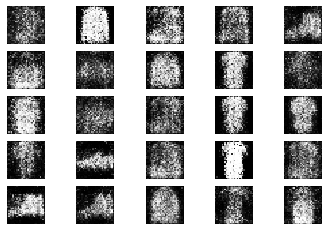

1001 [D loss: 0.602908, acc.: 67.19%] [G loss: 0.839016]
1002 [D loss: 0.628847, acc.: 64.06%] [G loss: 0.893616]
1003 [D loss: 0.630230, acc.: 67.19%] [G loss: 0.808799]
1004 [D loss: 0.613872, acc.: 71.88%] [G loss: 0.857689]
1005 [D loss: 0.661927, acc.: 59.38%] [G loss: 0.791098]
1006 [D loss: 0.623543, acc.: 62.50%] [G loss: 0.764444]
1007 [D loss: 0.635752, acc.: 57.81%] [G loss: 0.844718]
1008 [D loss: 0.619529, acc.: 64.06%] [G loss: 0.772878]
1009 [D loss: 0.677473, acc.: 56.25%] [G loss: 0.832899]
1010 [D loss: 0.604662, acc.: 64.06%] [G loss: 0.830371]
1011 [D loss: 0.686551, acc.: 50.00%] [G loss: 0.877650]
1012 [D loss: 0.651929, acc.: 67.19%] [G loss: 0.890650]
1013 [D loss: 0.642322, acc.: 62.50%] [G loss: 0.754140]
1014 [D loss: 0.622184, acc.: 60.94%] [G loss: 0.829101]
1015 [D loss: 0.670341, acc.: 62.50%] [G loss: 0.855221]
1016 [D loss: 0.661128, acc.: 59.38%] [G loss: 0.854254]
1017 [D loss: 0.629320, acc.: 70.31%] [G loss: 0.794666]
1018 [D loss: 0.636308, acc.: 6

1148 [D loss: 0.593309, acc.: 73.44%] [G loss: 0.868880]
1149 [D loss: 0.647303, acc.: 60.94%] [G loss: 0.795234]
1150 [D loss: 0.647778, acc.: 70.31%] [G loss: 0.825215]
1151 [D loss: 0.670294, acc.: 62.50%] [G loss: 0.915314]
1152 [D loss: 0.637318, acc.: 67.19%] [G loss: 0.860413]
1153 [D loss: 0.596429, acc.: 75.00%] [G loss: 0.879633]
1154 [D loss: 0.678285, acc.: 53.12%] [G loss: 0.878439]
1155 [D loss: 0.634080, acc.: 64.06%] [G loss: 0.921662]
1156 [D loss: 0.605735, acc.: 70.31%] [G loss: 0.876470]
1157 [D loss: 0.676962, acc.: 53.12%] [G loss: 0.907543]
1158 [D loss: 0.666615, acc.: 64.06%] [G loss: 0.905525]
1159 [D loss: 0.672220, acc.: 57.81%] [G loss: 0.855240]
1160 [D loss: 0.672295, acc.: 53.12%] [G loss: 0.873560]
1161 [D loss: 0.681897, acc.: 56.25%] [G loss: 0.834328]
1162 [D loss: 0.564278, acc.: 76.56%] [G loss: 0.794235]
1163 [D loss: 0.660829, acc.: 57.81%] [G loss: 0.871409]
1164 [D loss: 0.612526, acc.: 62.50%] [G loss: 0.815692]
1165 [D loss: 0.699256, acc.: 6

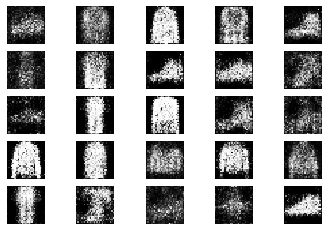

1201 [D loss: 0.620146, acc.: 65.62%] [G loss: 0.840421]
1202 [D loss: 0.676101, acc.: 51.56%] [G loss: 0.801300]
1203 [D loss: 0.612816, acc.: 68.75%] [G loss: 0.842069]
1204 [D loss: 0.612930, acc.: 65.62%] [G loss: 0.799852]
1205 [D loss: 0.638257, acc.: 67.19%] [G loss: 0.785367]
1206 [D loss: 0.643130, acc.: 60.94%] [G loss: 0.771601]
1207 [D loss: 0.644426, acc.: 64.06%] [G loss: 0.846816]
1208 [D loss: 0.661880, acc.: 62.50%] [G loss: 0.798681]
1209 [D loss: 0.589773, acc.: 75.00%] [G loss: 0.858785]
1210 [D loss: 0.700118, acc.: 48.44%] [G loss: 0.856202]
1211 [D loss: 0.642860, acc.: 64.06%] [G loss: 0.904603]
1212 [D loss: 0.619636, acc.: 64.06%] [G loss: 0.822540]
1213 [D loss: 0.677919, acc.: 59.38%] [G loss: 0.890528]
1214 [D loss: 0.616480, acc.: 65.62%] [G loss: 0.855373]
1215 [D loss: 0.606215, acc.: 68.75%] [G loss: 0.872468]
1216 [D loss: 0.604030, acc.: 71.88%] [G loss: 0.938260]
1217 [D loss: 0.568897, acc.: 73.44%] [G loss: 0.781868]
1218 [D loss: 0.577590, acc.: 7

1348 [D loss: 0.599451, acc.: 67.19%] [G loss: 0.900962]
1349 [D loss: 0.583680, acc.: 78.12%] [G loss: 0.856771]
1350 [D loss: 0.646390, acc.: 60.94%] [G loss: 0.836178]
1351 [D loss: 0.619251, acc.: 64.06%] [G loss: 0.814272]
1352 [D loss: 0.605722, acc.: 70.31%] [G loss: 0.856050]
1353 [D loss: 0.617249, acc.: 68.75%] [G loss: 0.829747]
1354 [D loss: 0.606843, acc.: 71.88%] [G loss: 0.831412]
1355 [D loss: 0.648286, acc.: 64.06%] [G loss: 0.839386]
1356 [D loss: 0.657942, acc.: 60.94%] [G loss: 0.892109]
1357 [D loss: 0.576554, acc.: 73.44%] [G loss: 0.915585]
1358 [D loss: 0.667956, acc.: 56.25%] [G loss: 0.916735]
1359 [D loss: 0.662377, acc.: 56.25%] [G loss: 0.844744]
1360 [D loss: 0.670139, acc.: 50.00%] [G loss: 0.864135]
1361 [D loss: 0.667495, acc.: 53.12%] [G loss: 0.865965]
1362 [D loss: 0.661291, acc.: 56.25%] [G loss: 0.814636]
1363 [D loss: 0.673915, acc.: 56.25%] [G loss: 0.840373]
1364 [D loss: 0.622057, acc.: 65.62%] [G loss: 0.875241]
1365 [D loss: 0.623702, acc.: 6

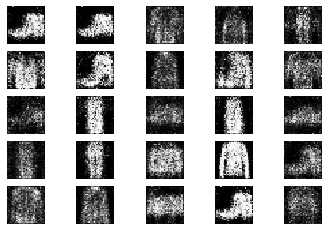

1401 [D loss: 0.592804, acc.: 71.88%] [G loss: 0.891590]
1402 [D loss: 0.616690, acc.: 68.75%] [G loss: 0.792619]
1403 [D loss: 0.644182, acc.: 65.62%] [G loss: 0.836009]
1404 [D loss: 0.651159, acc.: 57.81%] [G loss: 0.801667]
1405 [D loss: 0.638084, acc.: 70.31%] [G loss: 0.828607]
1406 [D loss: 0.627235, acc.: 65.62%] [G loss: 0.809430]
1407 [D loss: 0.654370, acc.: 62.50%] [G loss: 0.870415]
1408 [D loss: 0.640798, acc.: 62.50%] [G loss: 0.874438]
1409 [D loss: 0.687332, acc.: 60.94%] [G loss: 0.865355]
1410 [D loss: 0.589525, acc.: 71.88%] [G loss: 0.904080]
1411 [D loss: 0.628605, acc.: 67.19%] [G loss: 0.865234]
1412 [D loss: 0.653955, acc.: 57.81%] [G loss: 0.858403]
1413 [D loss: 0.650452, acc.: 59.38%] [G loss: 0.819677]
1414 [D loss: 0.646005, acc.: 70.31%] [G loss: 0.857856]
1415 [D loss: 0.656061, acc.: 65.62%] [G loss: 0.890491]
1416 [D loss: 0.621753, acc.: 56.25%] [G loss: 0.861814]
1417 [D loss: 0.647883, acc.: 62.50%] [G loss: 0.907876]
1418 [D loss: 0.593282, acc.: 6

1547 [D loss: 0.610336, acc.: 64.06%] [G loss: 0.822601]
1548 [D loss: 0.646166, acc.: 62.50%] [G loss: 0.844417]
1549 [D loss: 0.634711, acc.: 67.19%] [G loss: 0.835281]
1550 [D loss: 0.599583, acc.: 70.31%] [G loss: 0.852948]
1551 [D loss: 0.683390, acc.: 60.94%] [G loss: 0.894561]
1552 [D loss: 0.642209, acc.: 62.50%] [G loss: 0.889755]
1553 [D loss: 0.616947, acc.: 60.94%] [G loss: 0.941801]
1554 [D loss: 0.627220, acc.: 65.62%] [G loss: 0.934855]
1555 [D loss: 0.662527, acc.: 59.38%] [G loss: 0.850834]
1556 [D loss: 0.676284, acc.: 56.25%] [G loss: 0.872273]
1557 [D loss: 0.587517, acc.: 68.75%] [G loss: 0.918720]
1558 [D loss: 0.681760, acc.: 57.81%] [G loss: 0.871693]
1559 [D loss: 0.700209, acc.: 54.69%] [G loss: 0.781894]
1560 [D loss: 0.628541, acc.: 65.62%] [G loss: 0.864730]
1561 [D loss: 0.646667, acc.: 59.38%] [G loss: 0.885616]
1562 [D loss: 0.584571, acc.: 70.31%] [G loss: 0.888083]
1563 [D loss: 0.629483, acc.: 67.19%] [G loss: 0.805411]
1564 [D loss: 0.670972, acc.: 5

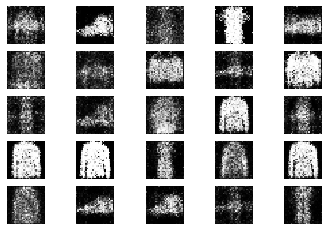

1601 [D loss: 0.633905, acc.: 60.94%] [G loss: 0.866671]
1602 [D loss: 0.667036, acc.: 56.25%] [G loss: 0.941590]
1603 [D loss: 0.630562, acc.: 67.19%] [G loss: 0.939035]
1604 [D loss: 0.652720, acc.: 59.38%] [G loss: 0.839874]
1605 [D loss: 0.562957, acc.: 73.44%] [G loss: 0.879743]
1606 [D loss: 0.618793, acc.: 65.62%] [G loss: 0.935390]
1607 [D loss: 0.623230, acc.: 56.25%] [G loss: 0.789120]
1608 [D loss: 0.651635, acc.: 59.38%] [G loss: 0.904888]
1609 [D loss: 0.639109, acc.: 62.50%] [G loss: 0.861448]
1610 [D loss: 0.635934, acc.: 65.62%] [G loss: 0.847522]
1611 [D loss: 0.658936, acc.: 54.69%] [G loss: 0.930885]
1612 [D loss: 0.634148, acc.: 60.94%] [G loss: 0.866572]
1613 [D loss: 0.605789, acc.: 68.75%] [G loss: 0.957785]
1614 [D loss: 0.614311, acc.: 68.75%] [G loss: 0.923456]
1615 [D loss: 0.678428, acc.: 60.94%] [G loss: 0.860004]
1616 [D loss: 0.624794, acc.: 64.06%] [G loss: 0.816536]
1617 [D loss: 0.628090, acc.: 57.81%] [G loss: 0.855387]
1618 [D loss: 0.682719, acc.: 5

1748 [D loss: 0.600930, acc.: 65.62%] [G loss: 0.911101]
1749 [D loss: 0.590615, acc.: 70.31%] [G loss: 0.846147]
1750 [D loss: 0.673377, acc.: 57.81%] [G loss: 0.856336]
1751 [D loss: 0.669708, acc.: 46.88%] [G loss: 0.881445]
1752 [D loss: 0.687814, acc.: 56.25%] [G loss: 0.888817]
1753 [D loss: 0.664343, acc.: 54.69%] [G loss: 0.965204]
1754 [D loss: 0.637203, acc.: 64.06%] [G loss: 0.985609]
1755 [D loss: 0.639866, acc.: 60.94%] [G loss: 0.940823]
1756 [D loss: 0.690629, acc.: 56.25%] [G loss: 0.885270]
1757 [D loss: 0.633940, acc.: 59.38%] [G loss: 0.820039]
1758 [D loss: 0.613538, acc.: 70.31%] [G loss: 0.885821]
1759 [D loss: 0.698365, acc.: 59.38%] [G loss: 0.872136]
1760 [D loss: 0.610832, acc.: 65.62%] [G loss: 0.851075]
1761 [D loss: 0.692146, acc.: 48.44%] [G loss: 0.886226]
1762 [D loss: 0.650771, acc.: 53.12%] [G loss: 0.814432]
1763 [D loss: 0.627191, acc.: 51.56%] [G loss: 0.820493]
1764 [D loss: 0.580236, acc.: 64.06%] [G loss: 0.838068]
1765 [D loss: 0.550522, acc.: 7

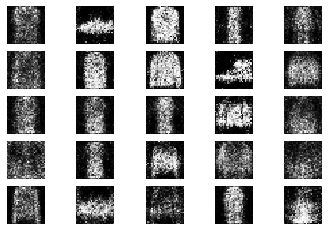

1801 [D loss: 0.598207, acc.: 65.62%] [G loss: 0.881040]
1802 [D loss: 0.651745, acc.: 67.19%] [G loss: 0.885973]
1803 [D loss: 0.649270, acc.: 60.94%] [G loss: 0.867453]
1804 [D loss: 0.618043, acc.: 65.62%] [G loss: 0.904235]
1805 [D loss: 0.583247, acc.: 76.56%] [G loss: 0.877166]
1806 [D loss: 0.612223, acc.: 51.56%] [G loss: 0.880855]
1807 [D loss: 0.656976, acc.: 60.94%] [G loss: 0.962734]
1808 [D loss: 0.550378, acc.: 78.12%] [G loss: 0.917569]
1809 [D loss: 0.628149, acc.: 57.81%] [G loss: 0.942922]
1810 [D loss: 0.621027, acc.: 70.31%] [G loss: 0.872320]
1811 [D loss: 0.673123, acc.: 64.06%] [G loss: 0.960113]
1812 [D loss: 0.625538, acc.: 64.06%] [G loss: 0.907841]
1813 [D loss: 0.642643, acc.: 57.81%] [G loss: 0.872234]
1814 [D loss: 0.603972, acc.: 71.88%] [G loss: 0.837718]
1815 [D loss: 0.626460, acc.: 62.50%] [G loss: 0.939732]
1816 [D loss: 0.623237, acc.: 64.06%] [G loss: 0.850687]
1817 [D loss: 0.648554, acc.: 57.81%] [G loss: 0.850314]
1818 [D loss: 0.610066, acc.: 7

1949 [D loss: 0.714032, acc.: 60.94%] [G loss: 0.839130]
1950 [D loss: 0.553087, acc.: 70.31%] [G loss: 0.884331]
1951 [D loss: 0.676105, acc.: 56.25%] [G loss: 0.828669]
1952 [D loss: 0.673482, acc.: 51.56%] [G loss: 0.824044]
1953 [D loss: 0.670305, acc.: 60.94%] [G loss: 0.831237]
1954 [D loss: 0.662122, acc.: 59.38%] [G loss: 0.936860]
1955 [D loss: 0.690937, acc.: 57.81%] [G loss: 0.897880]
1956 [D loss: 0.661860, acc.: 64.06%] [G loss: 0.905088]
1957 [D loss: 0.676310, acc.: 50.00%] [G loss: 0.845176]
1958 [D loss: 0.678853, acc.: 53.12%] [G loss: 0.845113]
1959 [D loss: 0.679128, acc.: 59.38%] [G loss: 0.892901]
1960 [D loss: 0.661018, acc.: 51.56%] [G loss: 0.888819]
1961 [D loss: 0.572190, acc.: 78.12%] [G loss: 0.952150]
1962 [D loss: 0.673068, acc.: 56.25%] [G loss: 0.898975]
1963 [D loss: 0.622343, acc.: 60.94%] [G loss: 0.919864]
1964 [D loss: 0.665259, acc.: 57.81%] [G loss: 0.965440]
1965 [D loss: 0.670885, acc.: 60.94%] [G loss: 1.022229]
1966 [D loss: 0.630828, acc.: 6

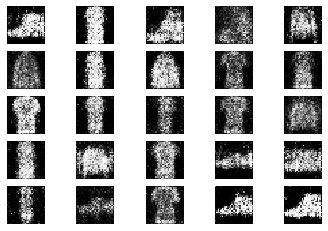

2001 [D loss: 0.576329, acc.: 67.19%] [G loss: 0.939262]
2002 [D loss: 0.637313, acc.: 60.94%] [G loss: 0.935327]
2003 [D loss: 0.691177, acc.: 59.38%] [G loss: 0.890222]
2004 [D loss: 0.582806, acc.: 70.31%] [G loss: 0.931925]
2005 [D loss: 0.617746, acc.: 64.06%] [G loss: 0.973511]
2006 [D loss: 0.632261, acc.: 68.75%] [G loss: 0.901662]
2007 [D loss: 0.655692, acc.: 64.06%] [G loss: 0.946949]
2008 [D loss: 0.644435, acc.: 60.94%] [G loss: 0.891728]
2009 [D loss: 0.643165, acc.: 59.38%] [G loss: 0.894151]
2010 [D loss: 0.618287, acc.: 64.06%] [G loss: 0.951588]
2011 [D loss: 0.626105, acc.: 70.31%] [G loss: 0.919721]
2012 [D loss: 0.619996, acc.: 71.88%] [G loss: 0.934324]
2013 [D loss: 0.626345, acc.: 67.19%] [G loss: 0.831373]
2014 [D loss: 0.579285, acc.: 73.44%] [G loss: 0.804139]
2015 [D loss: 0.633863, acc.: 64.06%] [G loss: 0.839903]
2016 [D loss: 0.711192, acc.: 51.56%] [G loss: 0.883595]
2017 [D loss: 0.619737, acc.: 65.62%] [G loss: 0.876264]
2018 [D loss: 0.616938, acc.: 6

2148 [D loss: 0.641882, acc.: 67.19%] [G loss: 0.868136]
2149 [D loss: 0.603926, acc.: 70.31%] [G loss: 0.911333]
2150 [D loss: 0.669184, acc.: 59.38%] [G loss: 0.877717]
2151 [D loss: 0.666452, acc.: 57.81%] [G loss: 0.850151]
2152 [D loss: 0.619602, acc.: 64.06%] [G loss: 0.859312]
2153 [D loss: 0.597033, acc.: 71.88%] [G loss: 0.917688]
2154 [D loss: 0.636186, acc.: 68.75%] [G loss: 0.869037]
2155 [D loss: 0.662550, acc.: 57.81%] [G loss: 0.885461]
2156 [D loss: 0.684826, acc.: 46.88%] [G loss: 0.913754]
2157 [D loss: 0.622493, acc.: 62.50%] [G loss: 0.938448]
2158 [D loss: 0.642415, acc.: 60.94%] [G loss: 0.998719]
2159 [D loss: 0.640026, acc.: 59.38%] [G loss: 0.882728]
2160 [D loss: 0.613451, acc.: 67.19%] [G loss: 0.842975]
2161 [D loss: 0.645257, acc.: 65.62%] [G loss: 0.845415]
2162 [D loss: 0.640975, acc.: 64.06%] [G loss: 0.889399]
2163 [D loss: 0.638557, acc.: 62.50%] [G loss: 0.845584]
2164 [D loss: 0.578940, acc.: 65.62%] [G loss: 0.866200]
2165 [D loss: 0.620216, acc.: 6

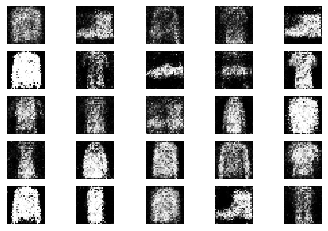

2201 [D loss: 0.598269, acc.: 62.50%] [G loss: 1.041538]
2202 [D loss: 0.615988, acc.: 68.75%] [G loss: 0.861272]
2203 [D loss: 0.613834, acc.: 67.19%] [G loss: 0.923918]
2204 [D loss: 0.641226, acc.: 64.06%] [G loss: 0.919458]
2205 [D loss: 0.695066, acc.: 67.19%] [G loss: 0.903475]
2206 [D loss: 0.638870, acc.: 67.19%] [G loss: 0.949101]
2207 [D loss: 0.603869, acc.: 71.88%] [G loss: 0.876371]
2208 [D loss: 0.623391, acc.: 64.06%] [G loss: 0.886450]
2209 [D loss: 0.559359, acc.: 71.88%] [G loss: 0.913029]
2210 [D loss: 0.639222, acc.: 68.75%] [G loss: 0.905370]
2211 [D loss: 0.595629, acc.: 68.75%] [G loss: 0.955365]
2212 [D loss: 0.611056, acc.: 57.81%] [G loss: 0.931692]
2213 [D loss: 0.626141, acc.: 65.62%] [G loss: 0.982027]
2214 [D loss: 0.624790, acc.: 68.75%] [G loss: 0.888892]
2215 [D loss: 0.676875, acc.: 64.06%] [G loss: 0.856491]
2216 [D loss: 0.584482, acc.: 71.88%] [G loss: 0.891273]
2217 [D loss: 0.663916, acc.: 54.69%] [G loss: 0.863078]
2218 [D loss: 0.710403, acc.: 4

2348 [D loss: 0.625481, acc.: 67.19%] [G loss: 0.942599]
2349 [D loss: 0.609753, acc.: 73.44%] [G loss: 1.013430]
2350 [D loss: 0.704151, acc.: 51.56%] [G loss: 0.874944]
2351 [D loss: 0.602869, acc.: 68.75%] [G loss: 0.904483]
2352 [D loss: 0.643472, acc.: 62.50%] [G loss: 0.851411]
2353 [D loss: 0.575746, acc.: 73.44%] [G loss: 0.841895]
2354 [D loss: 0.663014, acc.: 59.38%] [G loss: 0.895836]
2355 [D loss: 0.642824, acc.: 67.19%] [G loss: 0.892432]
2356 [D loss: 0.637304, acc.: 60.94%] [G loss: 0.970274]
2357 [D loss: 0.633864, acc.: 65.62%] [G loss: 0.932535]
2358 [D loss: 0.685688, acc.: 62.50%] [G loss: 0.889339]
2359 [D loss: 0.608778, acc.: 64.06%] [G loss: 0.899127]
2360 [D loss: 0.684487, acc.: 56.25%] [G loss: 0.995041]
2361 [D loss: 0.595171, acc.: 64.06%] [G loss: 1.001299]
2362 [D loss: 0.573514, acc.: 73.44%] [G loss: 0.961670]
2363 [D loss: 0.603360, acc.: 70.31%] [G loss: 0.932406]
2364 [D loss: 0.640834, acc.: 59.38%] [G loss: 0.873071]
2365 [D loss: 0.620541, acc.: 6

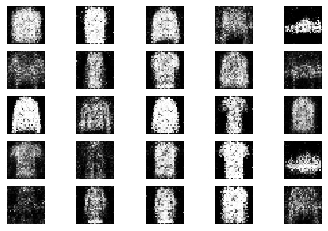

2401 [D loss: 0.642846, acc.: 64.06%] [G loss: 0.903797]
2402 [D loss: 0.634172, acc.: 68.75%] [G loss: 0.905216]
2403 [D loss: 0.637212, acc.: 65.62%] [G loss: 0.898629]
2404 [D loss: 0.631627, acc.: 62.50%] [G loss: 0.892678]
2405 [D loss: 0.552582, acc.: 79.69%] [G loss: 0.876650]
2406 [D loss: 0.645947, acc.: 64.06%] [G loss: 0.870089]
2407 [D loss: 0.623526, acc.: 67.19%] [G loss: 0.909565]
2408 [D loss: 0.605076, acc.: 68.75%] [G loss: 1.010620]
2409 [D loss: 0.659077, acc.: 57.81%] [G loss: 0.957984]
2410 [D loss: 0.588190, acc.: 71.88%] [G loss: 1.081735]
2411 [D loss: 0.655691, acc.: 54.69%] [G loss: 1.012465]
2412 [D loss: 0.654710, acc.: 59.38%] [G loss: 0.912227]
2413 [D loss: 0.629956, acc.: 65.62%] [G loss: 0.944077]
2414 [D loss: 0.628762, acc.: 64.06%] [G loss: 0.883321]
2415 [D loss: 0.620494, acc.: 68.75%] [G loss: 0.843528]
2416 [D loss: 0.649915, acc.: 67.19%] [G loss: 0.860499]
2417 [D loss: 0.637398, acc.: 64.06%] [G loss: 0.791931]
2418 [D loss: 0.615698, acc.: 6

2547 [D loss: 0.633425, acc.: 60.94%] [G loss: 0.886944]
2548 [D loss: 0.664688, acc.: 59.38%] [G loss: 0.880370]
2549 [D loss: 0.601480, acc.: 57.81%] [G loss: 0.998887]
2550 [D loss: 0.643046, acc.: 62.50%] [G loss: 0.970439]
2551 [D loss: 0.647562, acc.: 60.94%] [G loss: 0.861203]
2552 [D loss: 0.659354, acc.: 62.50%] [G loss: 0.995997]
2553 [D loss: 0.614699, acc.: 64.06%] [G loss: 0.889302]
2554 [D loss: 0.601440, acc.: 71.88%] [G loss: 0.871255]
2555 [D loss: 0.636789, acc.: 57.81%] [G loss: 0.913765]
2556 [D loss: 0.620941, acc.: 70.31%] [G loss: 0.897634]
2557 [D loss: 0.648026, acc.: 59.38%] [G loss: 0.858112]
2558 [D loss: 0.618865, acc.: 70.31%] [G loss: 0.951415]
2559 [D loss: 0.640922, acc.: 57.81%] [G loss: 0.978759]
2560 [D loss: 0.657305, acc.: 59.38%] [G loss: 1.003080]
2561 [D loss: 0.624234, acc.: 62.50%] [G loss: 0.935694]
2562 [D loss: 0.688969, acc.: 57.81%] [G loss: 0.930743]
2563 [D loss: 0.651490, acc.: 67.19%] [G loss: 0.961948]
2564 [D loss: 0.585600, acc.: 6

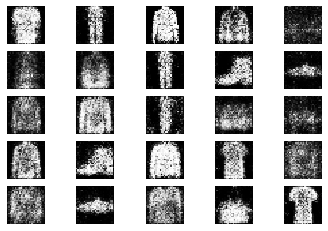

2601 [D loss: 0.642724, acc.: 65.62%] [G loss: 0.982547]
2602 [D loss: 0.617948, acc.: 67.19%] [G loss: 0.842666]
2603 [D loss: 0.602935, acc.: 70.31%] [G loss: 0.812630]
2604 [D loss: 0.615035, acc.: 65.62%] [G loss: 0.892456]
2605 [D loss: 0.649620, acc.: 62.50%] [G loss: 0.854968]
2606 [D loss: 0.620944, acc.: 65.62%] [G loss: 0.856097]
2607 [D loss: 0.623486, acc.: 60.94%] [G loss: 0.900740]
2608 [D loss: 0.616082, acc.: 62.50%] [G loss: 0.844213]
2609 [D loss: 0.663738, acc.: 54.69%] [G loss: 0.915880]
2610 [D loss: 0.563228, acc.: 75.00%] [G loss: 0.833342]
2611 [D loss: 0.598756, acc.: 70.31%] [G loss: 0.926893]
2612 [D loss: 0.703930, acc.: 57.81%] [G loss: 0.922799]
2613 [D loss: 0.641263, acc.: 62.50%] [G loss: 0.991553]
2614 [D loss: 0.651927, acc.: 54.69%] [G loss: 0.883798]
2615 [D loss: 0.610765, acc.: 64.06%] [G loss: 0.882659]
2616 [D loss: 0.593757, acc.: 65.62%] [G loss: 0.849231]
2617 [D loss: 0.637129, acc.: 57.81%] [G loss: 0.840203]
2618 [D loss: 0.622376, acc.: 6

2752 [D loss: 0.606084, acc.: 70.31%] [G loss: 0.918521]
2753 [D loss: 0.675976, acc.: 59.38%] [G loss: 0.827805]
2754 [D loss: 0.583804, acc.: 68.75%] [G loss: 0.881194]
2755 [D loss: 0.612443, acc.: 65.62%] [G loss: 0.898265]
2756 [D loss: 0.622101, acc.: 64.06%] [G loss: 0.987382]
2757 [D loss: 0.633375, acc.: 64.06%] [G loss: 0.857244]
2758 [D loss: 0.660214, acc.: 56.25%] [G loss: 0.979855]
2759 [D loss: 0.645780, acc.: 59.38%] [G loss: 1.003142]
2760 [D loss: 0.648775, acc.: 56.25%] [G loss: 0.935882]
2761 [D loss: 0.608506, acc.: 70.31%] [G loss: 0.957525]
2762 [D loss: 0.570260, acc.: 73.44%] [G loss: 0.947629]
2763 [D loss: 0.631720, acc.: 65.62%] [G loss: 0.973399]
2764 [D loss: 0.615329, acc.: 67.19%] [G loss: 0.897434]
2765 [D loss: 0.615700, acc.: 67.19%] [G loss: 0.923379]
2766 [D loss: 0.623727, acc.: 65.62%] [G loss: 0.901070]
2767 [D loss: 0.642504, acc.: 65.62%] [G loss: 0.983747]
2768 [D loss: 0.712784, acc.: 57.81%] [G loss: 0.899945]
2769 [D loss: 0.580832, acc.: 6

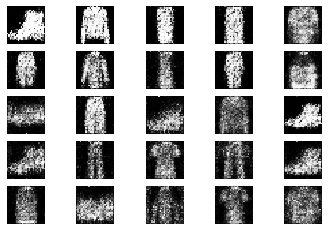

2801 [D loss: 0.677603, acc.: 54.69%] [G loss: 0.807882]
2802 [D loss: 0.604829, acc.: 65.62%] [G loss: 0.926373]
2803 [D loss: 0.653383, acc.: 56.25%] [G loss: 0.925519]
2804 [D loss: 0.587388, acc.: 73.44%] [G loss: 0.918354]
2805 [D loss: 0.732789, acc.: 59.38%] [G loss: 0.937915]
2806 [D loss: 0.648895, acc.: 65.62%] [G loss: 1.021861]
2807 [D loss: 0.565318, acc.: 71.88%] [G loss: 0.944355]
2808 [D loss: 0.637366, acc.: 60.94%] [G loss: 0.909364]
2809 [D loss: 0.639149, acc.: 62.50%] [G loss: 0.967645]
2810 [D loss: 0.638618, acc.: 62.50%] [G loss: 0.894092]
2811 [D loss: 0.590792, acc.: 67.19%] [G loss: 0.931475]
2812 [D loss: 0.557262, acc.: 75.00%] [G loss: 0.901797]
2813 [D loss: 0.586326, acc.: 71.88%] [G loss: 0.973457]
2814 [D loss: 0.617119, acc.: 70.31%] [G loss: 0.841208]
2815 [D loss: 0.606542, acc.: 70.31%] [G loss: 0.860638]
2816 [D loss: 0.589205, acc.: 60.94%] [G loss: 0.883109]
2817 [D loss: 0.609108, acc.: 62.50%] [G loss: 0.958221]
2818 [D loss: 0.634658, acc.: 6

2949 [D loss: 0.583057, acc.: 73.44%] [G loss: 0.960435]
2950 [D loss: 0.669748, acc.: 60.94%] [G loss: 0.828390]
2951 [D loss: 0.611863, acc.: 62.50%] [G loss: 0.888833]
2952 [D loss: 0.645070, acc.: 65.62%] [G loss: 0.971701]
2953 [D loss: 0.703394, acc.: 56.25%] [G loss: 0.932123]
2954 [D loss: 0.593832, acc.: 65.62%] [G loss: 0.930142]
2955 [D loss: 0.639136, acc.: 62.50%] [G loss: 0.859702]
2956 [D loss: 0.687450, acc.: 57.81%] [G loss: 0.840584]
2957 [D loss: 0.679143, acc.: 50.00%] [G loss: 0.868162]
2958 [D loss: 0.599707, acc.: 70.31%] [G loss: 0.876077]
2959 [D loss: 0.575376, acc.: 75.00%] [G loss: 0.892757]
2960 [D loss: 0.620453, acc.: 65.62%] [G loss: 0.835296]
2961 [D loss: 0.652335, acc.: 53.12%] [G loss: 0.909884]
2962 [D loss: 0.620569, acc.: 64.06%] [G loss: 0.900618]
2963 [D loss: 0.647601, acc.: 60.94%] [G loss: 0.914130]
2964 [D loss: 0.645224, acc.: 59.38%] [G loss: 0.838302]
2965 [D loss: 0.600479, acc.: 65.62%] [G loss: 0.858020]
2966 [D loss: 0.585705, acc.: 6

In [8]:
train(epochs=3000, batch_size=32, sample_interval=200)

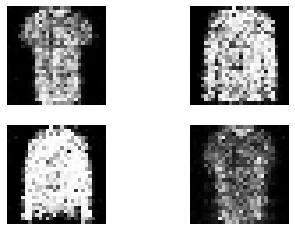

In [9]:
r, c = 2, 2
noise = np.random.normal(0, 1, (r * c, latent_dim))
gen_imgs = generator.predict(noise)

# Rescale images 0 - 1
gen_imgs = 0.5 * gen_imgs + 0.5

fig, axs = plt.subplots(r, c)
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
#fig.savefig("images/%d.png" % epoch)
plt.show()
plt.close()